In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder

In [33]:
root_path = "/home/stefan/ioai-prep/kits/sound_of_nature" # replace this with your dataset path
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 16

seed = 42
torch.random.manual_seed(seed)

# Data

In [34]:
train_df = pd.read_csv(os.path.join(root_path, "train.csv"))
test_df = pd.read_csv(os.path.join(root_path, "test.csv"))

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["class"])
num_classes = len(le.classes_)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, df, audio_dir, sr=16000, length=5):
        self.df = df
        self.audio_dir = audio_dir
        self.sr = sr
        self.target_len = sr * length
        self.mel = T.MelSpectrogram(sample_rate=sr, n_mels=64)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wav, sr = torchaudio.load(
            os.path.join(self.audio_dir, f"{row['sampleID']}.wav")
        )

        if sr != self.sr:
            wav = T.Resample(sr, self.sr)(wav)

        if wav.shape[1] < self.target_len:
            wav = torch.nn.functional.pad(wav, (0, self.target_len - wav.shape[1]))
        else:
            wav = wav[:, : self.target_len]

        mel = torch.log(self.mel(wav) + 1e-9)
        ret = {"mel": mel, "sample_id": row["sampleID"]}
        if "label" in row:
            ret["label"] = row["label"]
        return ret

    def __len__(self):
        return len(self.df)

In [36]:
train_dataset = AudioDataset(train_df, f"{root_path}/audio")
train_set, val_set = random_split(
    train_dataset,
    [int(0.8 * len(train_dataset)), len(train_dataset) - int(0.8 * len(train_dataset))],
)

train_loader = DataLoader(train_set, batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size)

test_dataset = AudioDataset(test_df, f"{root_path}/audio")
test_loader = DataLoader(test_dataset, batch_size)

In [37]:
# sanity check
batch = next(iter(train_loader))
{k:batch[k].shape for k in ["mel", "label"]}

{'mel': torch.Size([16, 1, 64, 401]), 'label': torch.Size([16])}

sample of chirping_birds


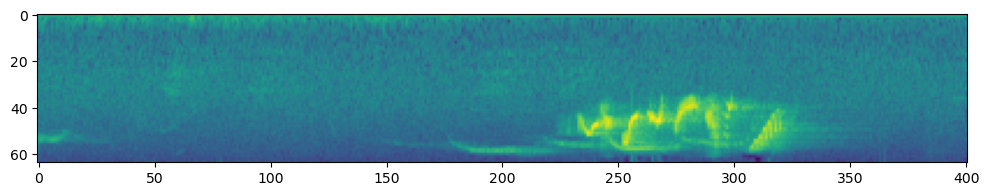

In [38]:
sample_idx = 1
sample = batch["mel"][sample_idx].permute(1, 2, 0)
print(f"sample of {le.inverse_transform([batch["label"][sample_idx]])[0]}")

plt.figure(figsize=(12, 3))
plt.imshow(sample)

# Submission

In [39]:
preds, sample_ids = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        mel = batch["mel"].to(device)

        # todo: placeholder for your model's predictions
        preds.extend([0] * batch["mel"].size(0))
        
        sample_ids.extend(batch["sample_id"])

Test: 100%|██████████| 5/5 [00:01<00:00,  4.48it/s]


In [40]:
submission = pd.DataFrame(
    {"sampleID": sample_ids, "class": [le.classes_[p] for p in preds]}
)

submission.head()

,sampleID,class
0,S_00003,cat
1,S_00011,cat
2,S_00013,cat
3,S_00017,cat
4,S_00019,cat


In [41]:
submission.to_csv("submission.csv", index=False)